# Palmer Penguins

This notebook uses [Palmer Penguins dataset](https://allisonhorst.github.io/palmerpenguins/) {cite:p}`palmerpenguins`. The dataset in CSV format used is downloaded from [here](https://gist.github.com/slopp/ce3b90b9168f2f921784de84fa445651).

The following tutorial is partly from [Increase citations, ease review & foster collaboration](https://ml.recipes) book by [Jesper Dramsch](https://ml.recipes).

Let's have the data loaded and briefly look at the data.

In [260]:
from pathlib import Path
import pandas as pd
import numpy as np

DATA_FOLDER = Path("..") / "data"
DATA_FILEPATH = DATA_FOLDER / "penguins.csv"
# Execute on cloud platform? (e.g. colab), try this path instead
# DATA_FILEPATH = "https://raw.githubusercontent.com/jeepchinnawat/edumat-book/main/data/penguins.csv"

penguins = pd.read_csv(DATA_FILEPATH)
penguins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   rowid              344 non-null    int64  
 1   species            344 non-null    object 
 2   island             344 non-null    object 
 3   bill_length_mm     342 non-null    float64
 4   bill_depth_mm      342 non-null    float64
 5   flipper_length_mm  342 non-null    float64
 6   body_mass_g        342 non-null    float64
 7   sex                333 non-null    object 
 8   year               344 non-null    int64  
dtypes: float64(4), int64(2), object(3)
memory usage: 24.3+ KB


In [261]:
penguins.head()

,rowid,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,1,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,2,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,3,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,4,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,5,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007


It looks like there is some missing values like in the row number 4 (and maybe more), which a little data cleaning can take care of.

In [262]:
penguins = penguins.dropna(axis='rows')
penguins.head()

,rowid,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,1,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,2,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,3,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
4,5,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007
5,6,Adelie,Torgersen,39.3,20.6,190.0,3650.0,male,2007


Making references to different selected groups of features and the target variable (to be classified) will help and be reused down the line.

In [263]:
num_features = ["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"]
cat_features = ["sex"]
features = num_features + cat_features
target = ["species"]
penguins = penguins[features+target]
penguins

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,species
0,39.1,18.7,181.0,3750.0,male,Adelie
1,39.5,17.4,186.0,3800.0,female,Adelie
2,40.3,18.0,195.0,3250.0,female,Adelie
4,36.7,19.3,193.0,3450.0,female,Adelie
5,39.3,20.6,190.0,3650.0,male,Adelie
...,...,...,...,...,...,...
339,55.8,19.8,207.0,4000.0,male,Chinstrap
340,43.5,18.1,202.0,3400.0,female,Chinstrap
341,49.6,18.2,193.0,3775.0,male,Chinstrap
342,50.8,19.0,210.0,4100.0,male,Chinstrap


## Exploratory Data Analysis
Let's have a look into the data in details with statistics and visualizations.

In [264]:
penguins.describe()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
count,333.000000,333.000000,333.000000,333.000000
mean,43.992793,17.164865,200.966967,4207.057057
std,5.468668,1.969235,14.015765,805.215802
min,32.100000,13.100000,172.000000,2700.000000
25%,39.500000,15.600000,190.000000,3550.000000
50%,44.500000,17.300000,197.000000,4050.000000
75%,48.600000,18.700000,213.000000,4775.000000
max,59.600000,21.500000,231.000000,6300.000000


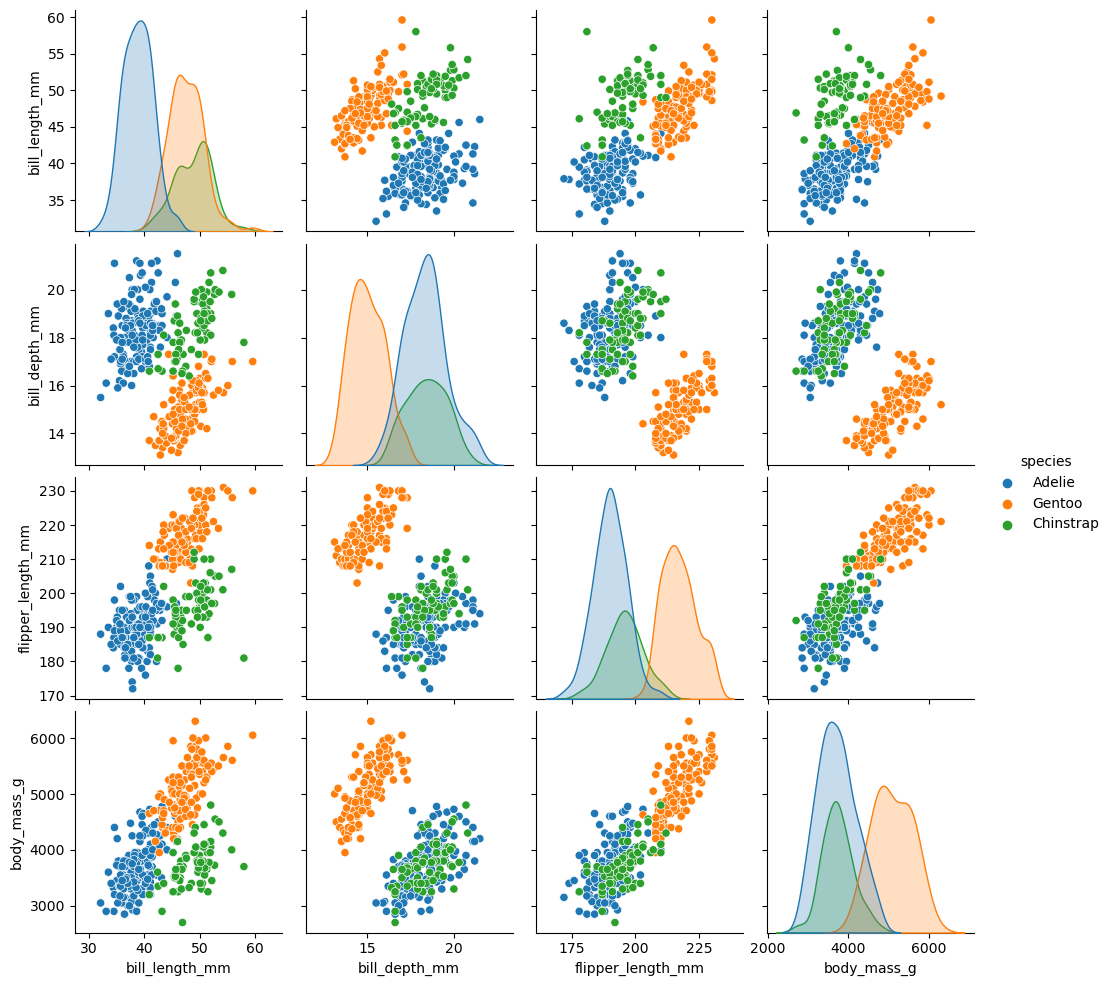

In [265]:
import seaborn as sns

pairplot_figure = sns.pairplot(penguins[num_features+['species']], hue="species")

The complete pairwise plots of our features show that there are 2-feature pairs between `bill_length_mm` and any of `bill_depth_mm`, `flipper_length_mm`, and `body_mass_g` being able to separate 3 species the best.

We will firstly make a classification model with 2 features for the sake of visualization. The selected features are `bill_length_mm` and `flipper_length_mm`.

In [266]:
selected_features = ['bill_length_mm', 'flipper_length_mm']
#feel free to experiment with other combinations.

## Data Splitting
Every supervised machine learning model needs a dataset to train on to be able to predict unseen data and that data splitting comes into play. We split the whole dataset into a training set, generally a bigger portion, and the rest as a testing set to act as unseen data for model evaluation.

In [267]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(penguins[selected_features], penguins[target[0]], random_state=20, train_size=.7)
X_train.head()

,bill_length_mm,flipper_length_mm
286,46.6,193.0
43,44.1,196.0
234,47.4,212.0
125,40.6,199.0
253,55.9,228.0


In [268]:
y_train.head()

286    Chinstrap
43        Adelie
234       Gentoo
125       Adelie
253       Gentoo
Name: species, dtype: object

In [269]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(233, 2)
(233,)
(100, 2)
(100,)


## Model Training
Now, let's build a classification model with Support-Vector Machine and train it with the training data set.

In [270]:
from sklearn.svm import SVC

svm = SVC()
svm.fit(X_train, y_train)

SVC()

Okay, we get a decent accuracy score on the training data.

In [271]:
svm.score(X_train, y_train)

0.7982832618025751

To see how well our model predicts unseen data, we evaluate the model against the test set.

In [272]:
svm.score(X_test, y_test)

0.81

Let's see how our SVM model learn to distinguish the (training) data from 3 species visually.

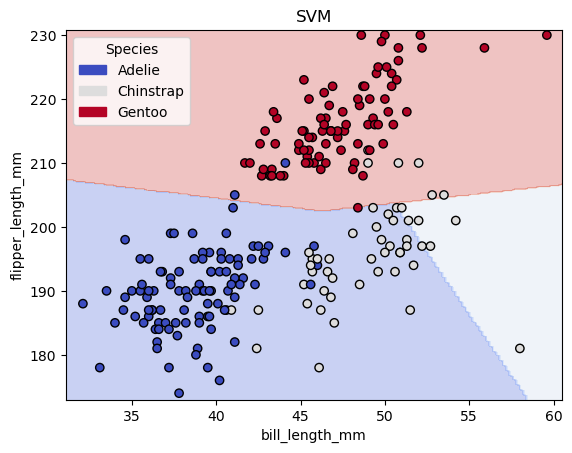

In [274]:
import matplotlib.pyplot as plt
import matplotlib.patches

def plot_svm2d(X, f1, f2, y, svm):
    # create a predicted mesh
    s = 0.2
    x_min, x_max = X[f1].min() - 1, X[f1].max() + 1
    y_min, y_max = X[f2].min() - 1, X[f2].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, s), np.arange(y_min, y_max, s))
    df = {f1: xx.ravel(),f2: yy.ravel()}
    xy = pd.DataFrame(df)
    Z = svm.predict(xy)
    fig, ax = plt.subplots()
    
    # Fill the plot with predicted mesh
    levels, categories = pd.factorize(Z, sort=True)
    levels = levels.reshape(xx.shape)
    ax.contourf(xx, yy, levels, cmap=plt.cm.coolwarm, alpha=0.3)

    # data scatter plot
    levels, categories = pd.factorize(y, sort=True)
    handles = [matplotlib.patches.Patch(color=plt.cm.coolwarm.resampled(3)(i), label=c) for i, c in enumerate(categories)]
    ax.scatter(X[f1], X[f2], c=levels, cmap=plt.cm.coolwarm, edgecolors='black')
    ax.set_xlabel('bill_length_mm')
    ax.set_ylabel('flipper_length_mm')
    ax.set_title("SVM")
    ax.legend(handles=handles, title='Species')
    plt.show()

plot_svm2d(X_train, selected_features[0], selected_features[1], y_train, svm)

As you can see, our SVM misclassifies a lot of Chinstrap penquins in the train set. Something we can do here is to scale our numerical features. This is crucial for many machine learning algorithms, as they can be sensitive to the scale of the input features.

It can be observed from the plot above that the range of `flipper_length_mm` covering the data is twice as wide as that of `bill_length_mm`. You can scale these features into an equal range with `StandardScaler`. With `Pipeline` introduced here, you can integrate pre-processors and a machine learning model into a convenient workflow with possibilities beyond this example.

In [275]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

num_scaler = StandardScaler()

model = Pipeline(steps=[
    ('scaler', num_scaler),
    ('classifier', SVC())
])
model

Pipeline(steps=[('scaler', StandardScaler()), ('classifier', SVC())])

Now, it's time to train and see the result from our improved model.

Training set Accuracy: 0.9484978540772532
Testing set Accuracy: 0.96


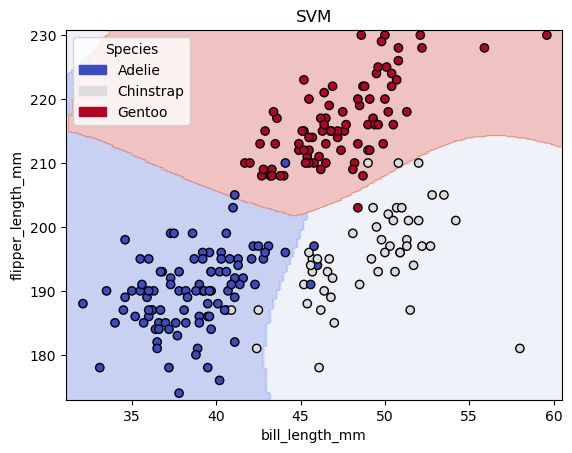

In [276]:
model.fit(X_train, y_train)
print(f'Training set Accuracy: {model.score(X_train, y_train)}')
print(f'Testing set Accuracy: {model.score(X_test, y_test)}')
plot_svm2d(X_train, selected_features[0], selected_features[1], y_train, model)

Our model now generalizes much better with a simple scaling trick!

## Model 

In [277]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.metrics import matthews_corrcoef as mcc
from sklearn.metrics import accuracy_score as acc
from sklearn.utils import resample

from ipywidgets import interact
import ipywidgets as widgets

def svm_interact(sFeatures, trainsize, mislabel):
    status_widget.value = 'Calculating...'
    selected = np.array(sFeatures)
    X, y = penguins[selected], penguins[target[0]]
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=trainsize, random_state=21, stratify=y)

    if mislabel > 0.0:
        y_mis = resample(y_train, n_samples=int(y_train.shape[0]*mislabel), replace=False, random_state=21)
        for i in y_mis.index:
            label=['Chinstrap','Gentoo','Adelie']
            label.remove(y_mis[i])
            newlabel = resample(label, n_samples=1)[0]
            y_train[i] = newlabel

    num_transformer = StandardScaler()
    cat_transformer = OneHotEncoder(handle_unknown='ignore')
    if 'sex' in selected:
        transformers=[
            ('num', num_transformer, selected[:-1]),
            ('cat', cat_transformer, selected[-1:])
        ]
    else:
        transformers=[
            ('num', num_transformer, selected)
        ]
        
    preprocessor = ColumnTransformer(transformers=transformers)
    
    
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', SVC()),
    ])

    mcc_scorer = make_scorer(mcc)
    acc_scorer = make_scorer(acc)
    scores = cross_validate(model, X_train, y_train, cv=5,
                            scoring={"MCC": mcc_scorer, "ACC": acc_scorer})

    print("Cross Validation on training set")
    for k, v in scores.items():
        print(k, " : ", v)
    print("Avg ACC in CV: ", np.average(scores["test_ACC"]))
    print("Avg MCC in CV: ", np.average(scores["test_MCC"]))
    print()

    X2_train, X2_test, y2_train, y2_test = train_test_split(X_train, y_train, train_size=0.8, random_state=21, stratify=y_train)
    model = model.fit(X2_train, y2_train)
    print("Evaluation on test set")
    print("ACC: ", acc_scorer(model, X2_test, y2_test))
    print("MCC: ", mcc_scorer(model, X2_test, y2_test))
    
    status_widget.value = 'Calculation completed!'

features_widget = widgets.SelectMultiple(
    options=features,
    value=[features[0], features[1]],
    description='Features:',
    disabled=False
)
trainsize_widget = widgets.FloatSlider(
    value=0.7,
    min=0.5,
    max=0.8,
    step=0.05,
    description='%train data:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.0%',
)
mislabel_widget = widgets.FloatSlider(
    value=0.0,
    min=0.0,
    max=0.5,
    step=0.005,
    description='Mislabeled:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1%',
)
status_widget = widgets.Label(value='')

interact(svm_interact, sFeatures=features_widget, trainsize=trainsize_widget, mislabel=mislabel_widget)
display(status_widget)

interactive(children=(SelectMultiple(description='Features:', index=(0, 1), options=('bill_length_mm', 'bill_d…

Label(value='Calculation completed!')